In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_profiling as pdp
from sklearn.model_selection import train_test_split
import lightgbm as lgb
os.environ['KMP_DUPLICATE_LIB_OK']='True'

/Users/a_yoshino/anaconda3/envs/gasyori100/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train = pd.read_csv('../home-credit-default-risk/application_train.csv')
test = pd.read_csv('../home-credit-default-risk/application_test.csv')
bureau = pd.read_csv('../home-credit-default-risk/bureau.csv')
bureau_b = pd.read_csv('../home-credit-default-risk/bureau_balance.csv')
prep = pd.read_csv('../home-credit-default-risk/previous_application.csv')

## application_train.csv

In [3]:
print('train.shape: ', train.shape)
train.head()

train.shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
#missingData percentage
hig_mis_columns = train.loc[:,train.isnull().sum()/len(train) > 0.60].columns
hig_mis_columns

Index(['OWN_CAR_AGE', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'FLOORSMIN_AVG',
       'LIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_AVG', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'FLOORSMIN_MODE', 'LIVINGAPARTMENTS_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       'FLOORSMIN_MEDI', 'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MEDI',
       'FONDKAPREMONT_MODE'],
      dtype='object')

以上が60%以上の欠損値カラムを削除する

In [5]:
new_train = train.drop(hig_mis_columns, axis=1)
new_train.shape

(307511, 105)

In [6]:
new_test = test.drop(hig_mis_columns, axis=1)
new_test.shape

(48744, 104)

## merge bureau.csv & application_train.csv

In [7]:
print('train: ', new_train.shape)
print('bureau: ', bureau.shape)

train:  (307511, 105)
bureau:  (1716428, 17)


trainのデータ数よりbureauのデータ数の方が少ない<br>
=　各SK_ID_CURRにbureauデータが必ずあるわけではない

In [8]:
train_with_bureau = train.loc[train['SK_ID_CURR'].isin(bureau['SK_ID_CURR']), :]
print('train with bureau count: ', len(train_with_bureau))

train with bureau count:  263491


In [9]:
test_with_bureau = test.loc[test['SK_ID_CURR'].isin(bureau['SK_ID_CURR']), :]
print('test with bureau count: ', len(test_with_bureau))

test with bureau count:  42320


In [10]:
print('bureau all: ', len(train_with_bureau)+len(test_with_bureau))

bureau all:  305811


In [11]:
train_bu = pd.merge(new_train, bureau, on='SK_ID_CURR', how ='inner')
test_bu = pd.merge(new_test, bureau, on='SK_ID_CURR', how ='inner')

## merge bureau_balance.csv

In [12]:
bureau_b.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [13]:
print('len train_bu : ', len(train_bu))
print('len test_bu : ', len(test_bu))
print('len bureau_balance: ', len(bureau_b))

len train_bu :  1465325
len test_bu :  251103
len bureau_balance:  27299925


In [14]:
train = pd.merge(train_bu, bureau_b, on='SK_ID_BUREAU', how ='inner')
test = pd.merge(test_bu, bureau_b, on='SK_ID_BUREAU', how ='inner')

## bureau data EDA

###  checking column content

In [15]:
# profile = pdp.ProfileReport(train)
# profile.to_file(outputfile="bureau_data_profile.html")

<strong>missing values</strong><br>
ランダムフォレストに入れる想定のため、欠損値埋めはしない。<br>
精度が低ければ、特徴量ごと削除を検討。

<strong><カテゴリー分けされているもの></strong><br>
CODE_GENDER<br>
CREDIT_ACTIVE<br>
CREDIT_CURRENCY<br>
CREDIT_TYPE<br>
EMERGENCYSTATE_MODE<br>
FLAG_OWN_CAR<br>
FLAG_OWN_REALTY<br>
HOUSETYPE_MODE<br>
NAME_CONTRACT_TYPE<br>
NAME_EDUCATION_TYPE<br>
NAME_FAMILY_STATUS<br>
NAME_HOUSING_TYPE<br>
NAME_INCOME_TYPE<br>
NAME_TYPE_SUITE<br>
OCCUPATION_TYPE<br>
ORGANIZATION_TYPE<br>
STATUS<br>
WALLSMATERIAL_MODE<br>
WEEKDAY_APPR_PROCESS_START<br>

In [16]:
category_colm = np.array(['CODE_GENDER',
'CREDIT_ACTIVE',
'CREDIT_CURRENCY',
'CREDIT_TYPE',
'EMERGENCYSTATE_MODE',
'FLAG_OWN_CAR',
'FLAG_OWN_REALTY',
'HOUSETYPE_MODE',
'NAME_CONTRACT_TYPE',
'NAME_EDUCATION_TYPE',
'NAME_FAMILY_STATUS',
'NAME_HOUSING_TYPE',
'NAME_INCOME_TYPE',
'NAME_TYPE_SUITE',
'OCCUPATION_TYPE',
'ORGANIZATION_TYPE',
'STATUS',
'WALLSMATERIAL_MODE',
'WEEKDAY_APPR_PROCESS_START'])

In [17]:
#dummy varible 
new_train_clm = pd.concat([pd.get_dummies(train[clm_name]) for clm_name in category_colm], axis=1)
new_test_clm = pd.concat([pd.get_dummies(test[clm_name]) for clm_name in category_colm], axis=1)

In [18]:
#既存データからカテゴリー変数を除き、ダミー変数を加える
train = train.drop(category_colm, axis=1)
test = test.drop(category_colm, axis=1)

train = pd.concat([train, new_train_clm], axis=1)
test = pd.concat([test, new_test_clm], axis=1)

In [19]:
#split target
y_train = train['TARGET']
x_train = train.drop('TARGET', axis=1)

## Light GBM

In [20]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=18)
lgb_train = lgb.Dataset(data=x_train, label=y_train)
lgb_eval = lgb.Dataset(data=x_val, label=y_val)

In [21]:
params = {
'task': 'train',
'boosting_type': 'gbdt', 
'objective': 'binary', 
'metric': 'auc', 
'learning_rate': 0.01,
'num_leaves': 48,
'num_iteration': 5000,
'verbose': 0 ,
'colsample_bytree':.8,
'subsample':.9,
'max_depth':7,
'reg_alpha':.1,
'reg_lambda':.1, 
'min_split_gain':.01, 
'min_child_weight':1
}

In [22]:
model = lgb.train(params, lgb_train, valid_sets=lgb_eval, early_stopping_rounds=150, verbose_eval=200)

/Users/a_yoshino/anaconda3/envs/gasyori100/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.827303
[400]	valid_0's auc: 0.872661
[600]	valid_0's auc: 0.897801
[800]	valid_0's auc: 0.91139
[1000]	valid_0's auc: 0.921723
[1200]	valid_0's auc: 0.93029
[1400]	valid_0's auc: 0.938696
[1600]	valid_0's auc: 0.945731
[1800]	valid_0's auc: 0.952187
[2000]	valid_0's auc: 0.957726
[2200]	valid_0's auc: 0.96259
[2400]	valid_0's auc: 0.966951
[2600]	valid_0's auc: 0.970394
[2800]	valid_0's auc: 0.973716
[3000]	valid_0's auc: 0.976643
[3200]	valid_0's auc: 0.978891
[3400]	valid_0's auc: 0.980728
[3600]	valid_0's auc: 0.982449
[3800]	valid_0's auc: 0.98411
[4000]	valid_0's auc: 0.985462
[4200]	valid_0's auc: 0.98689
[4400]	valid_0's auc: 0.988134
[4600]	valid_0's auc: 0.989296
[4800]	valid_0's auc: 0.990206
[5000]	valid_0's auc: 0.99102
Did not meet early stopping. Best iteration is:
[5000]	valid_0's auc: 0.99102


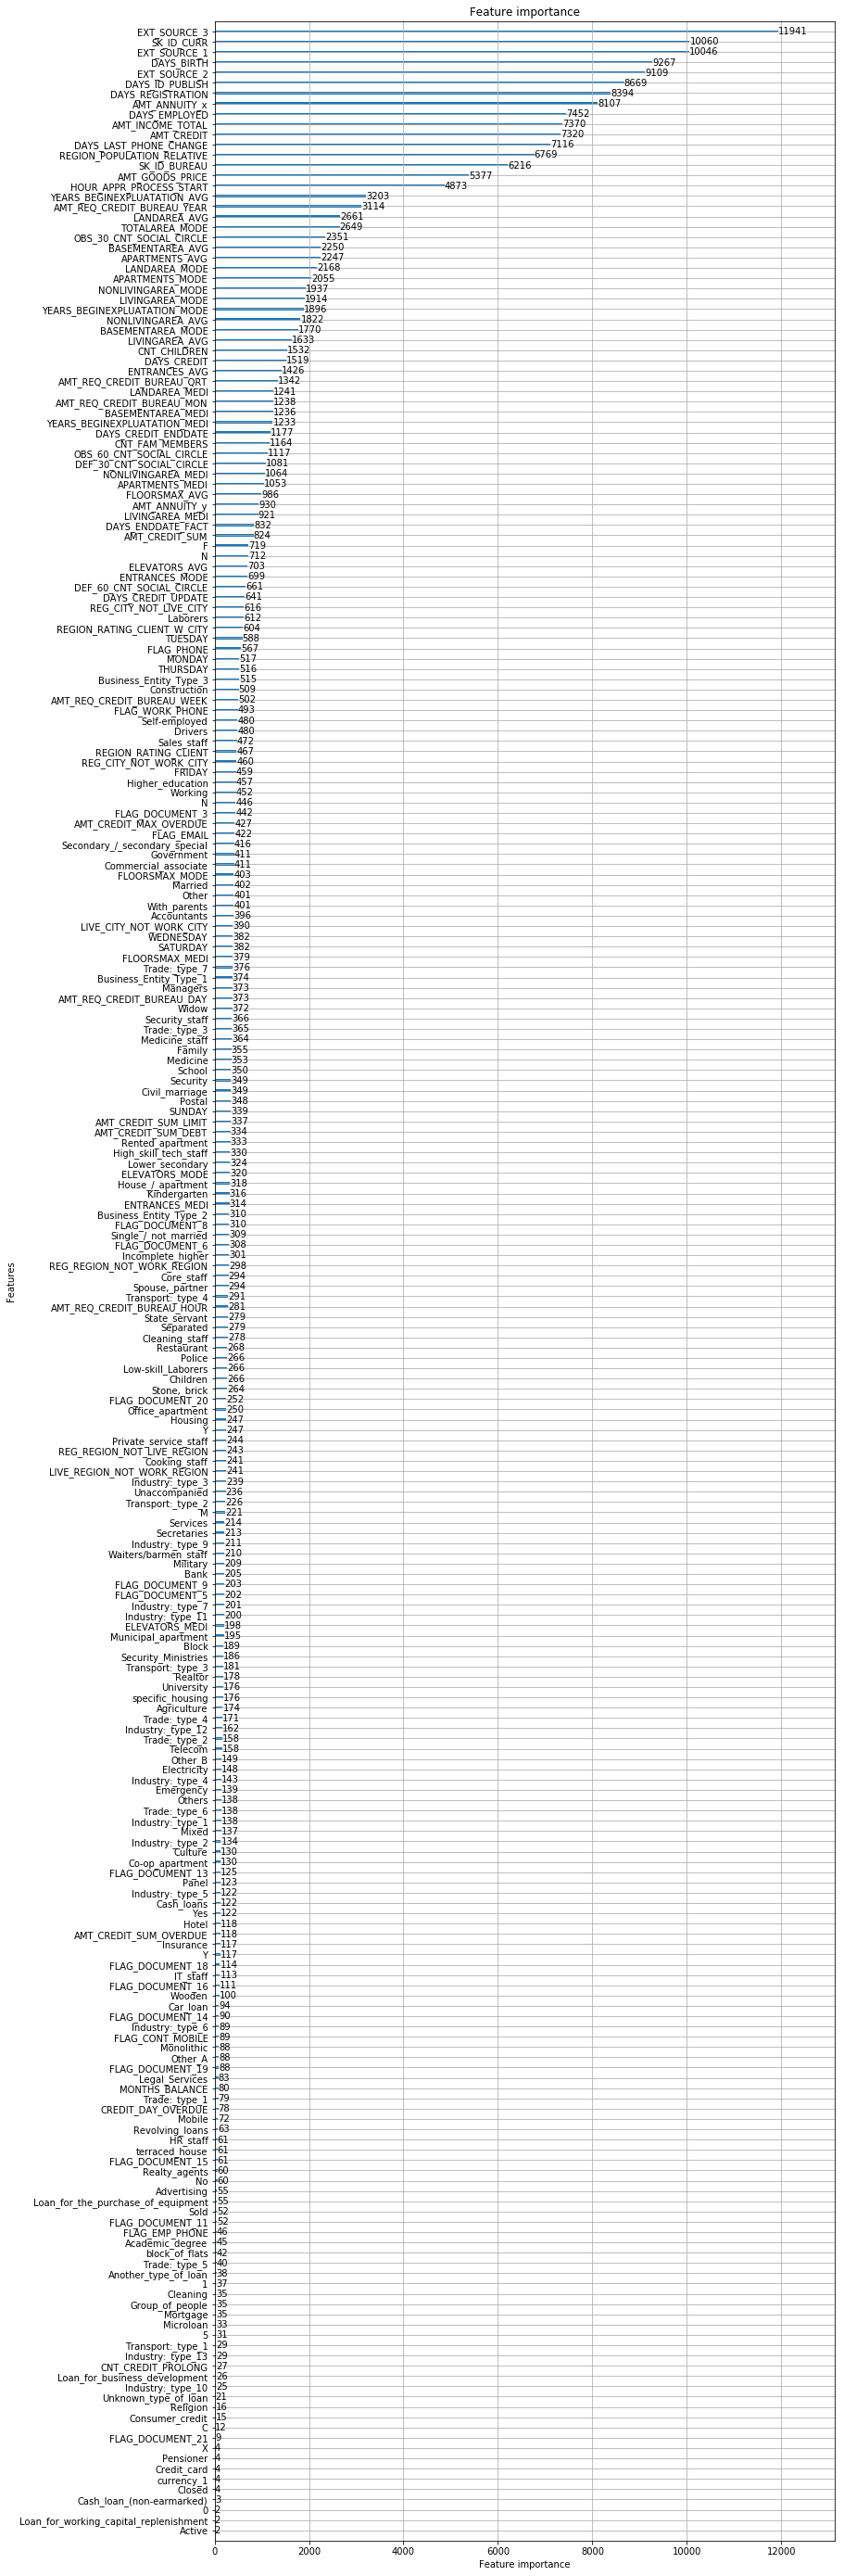

In [23]:
importance_list = lgb.plot_importance(model, figsize=(12, 50));

In [ ]:
train.to_csv('../pre_csv/pre_app_bureau_train.csv', index=False)
test.to_csv('../pre_csv/pre_app_bureau_test.csv', index=False)